In [1]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

from IPython.display import display as d

In [2]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784, 1)
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz").reshape((-1, 1))
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0)).reshape(-1, 784, 1)
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz").reshape((-1, 1))

In [3]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 784, 1)
(12000, 1)
(1000, 784, 1)
(1000, 1)


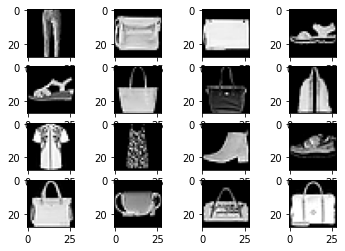

In [4]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(devxs))].reshape(28, 28))

In [20]:
print(trainys[0, :15])

[0]


In [6]:
# Hyperparameters
learning_rate = alpha = 0.01
Din = trainxs[0].shape[0]
h1 = 200
h2 = 20
Dout = 1

In [7]:
def loss(y_pred, y):
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

# def loss_prime(y_pred, y):
#     if (y_pred - (y_pred ** 2)) == 0:
#         return 1
#     return (y_pred - y) / (y_pred - (y_pred ** 2))
# loss_prime = lambda y_pred, y: y_pred - y
def loss_prime(y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [8]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
sigmoid_prime = lambda x: sigmoid(x) * (1 - sigmoid(x))
init_param = lambda shape: np.random.random(shape) / 100

class ThreeLayerPerceptron():
    def __init__(self, Din, h1, h2):
        self.Din = Din
        self.h1 = h1
        self.h2 = h2
        self.Dout = 1
        
        self.W1 = init_param((self.h1, self.Din))
        self.W2 = init_param((self.h2, self.h1))
        self.w3 = init_param((1, self.h2))
        self.b1 = init_param((self.h1, 1))
        self.b2 = init_param((self.h2, 1))
        self.b3 = init_param((self.Dout, self.Dout))
    
    def forward_old(self, x, W1=None, b1=None, W2=None, b2=None, w3=None, b3=None):
        """
        Parameters
        ----------
        x : np.array(Din, 1)
            Individual datapoint

        
        Returns
        -------
        ypred : np.array(1)
            Predicted Y
        """
        if W1 is None:
            W1 = self.W1
        if b1 is None:
            b1 = self.b1
        if W2 is None:
            W2 = self.W2
        if b2 is None:
            b2 = self.b2
        if w3 is None:
            w3 = self.w3
        if b3 is None:
            b3 = self.b3
        
        a1 = sigmoid(W1 @ x + b1)
        a2 = sigmoid(W2 @ a1 + b2)
        ypred = a3 = sigmoid(w3 @ a2 + b3)
        return ypred

In [9]:
mlp = ThreeLayerPerceptron(Din, h1, h2)

In [10]:
def backward(x, y, m):    
    z1 = m.W1.dot(x) + m.b1
    a1 = sigmoid(z1)
    z2 = m.W2.dot(a1) + m.b2
    a2 = sigmoid(z2)
    z3 = m.w3.dot(a2) + m.b3
    y_pred = a3 = sigmoid(z3)
    # h1 = 200, h2 = 20
    L = loss(y_pred, y)
    dL_dz3 = loss_prime(y_pred, y) * sigmoid_prime(z3) # (1, 1)
    dL_dz2 = dL_dz3.dot(m.w3) * sigmoid_prime(z2).T
    dL_dz1 = dL_dz2.dot(m.W2) * sigmoid_prime(z1).T # (1, h1)
    
    grad_w3 = a2.dot(dL_dz3) # (h2, 1)
    grad_W2 = a1.dot(dL_dz2) # (h1, h2)
    grad_W1 = x.dot(dL_dz1) # (Din, h2)

    grad_b3 = np.sum(dL_dz3, axis=0).reshape(m.b3.shape) # (1,)
    grad_b2 = np.sum(dL_dz2, axis=0).reshape(m.b2.shape) # (20,)
    grad_b1 = np.sum(dL_dz1, axis=0).reshape(m.b1.shape) # (200,)
    
    return grad_w3, grad_W2, grad_W1, grad_b3, grad_b2, grad_b1

In [11]:
ci = 2
somex = trainxs[ci]
somey = trainys[ci]
grad_w3, grad_W2, grad_W1, grad_b3, grad_b2, grad_b1 = backward(somex, somey, mlp)

# Gradient Check

## $b_3$ grad

In [32]:
def fd_grad_b3(b3p, i, m):
    epsilon = 1e-6
    upper = loss(m.forward_old(trainxs[i], b3=(b3p + epsilon)), trainys[i])
    lower = loss(m.forward_old(trainxs[i], b3=(b3p - epsilon)), trainys[i])
    fd = (upper - lower) / (2 * epsilon)
    return fd
fd_grad_b3_i = fd_grad_b3(mlp.b3, ci, mlp)
(fd_grad_b3_i - grad_b3)

array([[-1.13723864e-10]])

## $b_2$ grad

In [30]:
def fd_grad_b2(m, i):
    epsilon = 1e-6
    b2vec = m.b2.squeeze()
    x = trainxs[i]
    y = trainys[i]
    output = np.zeros_like(b2vec)
    for i in range(b2vec.size):
        b2vecu = b2vec.copy()
        b2vecl = b2vec.copy()
        b2vecu[i] += epsilon
        b2vecl[i] -= epsilon
        l = loss(m.forward_old(x, b2=b2vecu.reshape((-1, 1))), y)
        r = loss(m.forward_old(x, b2=b2vecl.reshape((-1, 1))), y)
        output[i] = ((l - r) / (2 * epsilon))
    return output.reshape(m.b2.shape)
fd_grad_b2_i = fd_grad_b2(mlp, ci)
print((fd_grad_b2_i - grad_b2).max())
fd_grad_b2_i - grad_b2

1.2419780698672e-10


array([[-5.34386229e-13],
       [-4.23718205e-11],
       [-2.39312143e-11],
       [-2.67873882e-11],
       [-2.26475776e-11],
       [ 1.24197807e-10],
       [ 1.94021354e-11],
       [-5.10482550e-11],
       [ 7.80354464e-11],
       [ 2.14903452e-11],
       [ 1.57294024e-11],
       [ 4.54220011e-11],
       [ 7.61697127e-11],
       [-4.29226043e-11],
       [ 8.68323206e-11],
       [ 1.15440590e-11],
       [ 1.93518847e-11],
       [ 3.12296103e-11],
       [ 1.79508888e-11],
       [ 5.81254167e-11]])

## $b_1$ grad

In [34]:
def fd_grad_b1(m, i):
    epsilon = 1e-6
    b1vec = m.b1.squeeze()
    x = trainxs[i]
    y = trainys[i]
    output = np.zeros_like(b1vec)
    for i in range(b1vec.size):
        b1vecu = b1vec.copy()
        b1vecl = b1vec.copy()
        b1vecu[i] += epsilon
        b1vecl[i] -= epsilon
        l = loss(m.forward_old(x, b1=b1vecu.reshape((-1, 1))), y)
        r = loss(m.forward_old(x, b1=b1vecl.reshape((-1, 1))), y)
        output[i] = ((l - r) / (2 * epsilon))
    return output.reshape(m.b1.shape)
fd_grad_b1_i = fd_grad_b1(mlp, ci)
print((fd_grad_b1(mlp, ci) - grad_b1).max())
(fd_grad_b1_i - grad_b1)[:30] # Clip from (1, 200)

1.211741485383983e-10


array([[-9.47119842e-12],
       [-3.08712782e-11],
       [-5.81643012e-11],
       [-7.53231405e-11],
       [-6.01931428e-11],
       [-3.46446791e-11],
       [ 8.24412962e-12],
       [-2.74955935e-11],
       [ 6.78759572e-11],
       [-9.56121429e-11],
       [ 1.63917382e-11],
       [-4.11565798e-11],
       [ 2.84083828e-12],
       [ 6.82897970e-12],
       [-6.66000679e-11],
       [ 1.05097125e-10],
       [-1.55700294e-11],
       [ 7.23396813e-11],
       [ 1.58497133e-11],
       [ 7.55396329e-11],
       [ 6.11622674e-12],
       [-1.43147145e-11],
       [-5.49120646e-11],
       [-4.51170988e-11],
       [ 7.93052597e-11],
       [ 4.33715325e-11],
       [ 1.03101900e-10],
       [ 8.95445565e-11],
       [ 1.07271803e-10],
       [-5.50755541e-12]])

## $w_3$ grad

In [25]:
def fd_grad_w3(m, i):
    epsilon = 1.e-6
    w3shape = m.w3.shape
    w3f = m.w3.copy().flatten()
    gradfd_w3f = w3f.copy()
    x = trainxs[i]
    y = trainys[i]
    for i in range(w3f.size):
        w3fupper = w3f.copy()
        w3flower = w3f.copy()
        w3fupper[i] += epsilon
        w3flower[i] -= epsilon
        
        w3upper = w3fupper.reshape(w3shape)
        w3lower = w3flower.reshape(w3shape)
        
        a1 = sigmoid(m.W1.dot(x) + m.b1)
        a2 = sigmoid(m.W2.dot(a1) + m.b2)
        
        a3upper = sigmoid(w3upper.dot(a2) + m.b3)
        a3lower = sigmoid(w3lower.dot(a2) + m.b3)
        upper = loss(a3upper, y)
        lower = loss(a3lower, y)
        
        fd = (upper - lower) / (2 * epsilon)
        gradfd_w3f[i] = fd
    
    gradfd_w3 = gradfd_w3f.reshape(w3shape)
    return gradfd_w3
fd_grad_w3_i = fd_grad_w3(mlp, ci)
print((fd_grad_w3_i - grad_w3.squeeze()).max())
print(fd_grad_w3_i - grad_w3.squeeze())

1.2085332734557142e-10
[[-8.77082296e-11 -1.42243717e-10 -8.06731904e-11  1.76235138e-11
   2.08982831e-11 -4.27144986e-11  3.91829902e-11  4.97046293e-11
  -3.72049613e-11 -1.85797489e-11  8.30415736e-11 -7.80692178e-11
   4.24477120e-12 -5.57425217e-11  6.09976514e-11 -7.06651959e-11
   3.78210241e-11  5.33005307e-11  7.05116521e-11  1.20853327e-10]]


## $W_2$ grad

In [21]:
def fd_grad_W2(m, i):
    epsilon = 1e-6
    W2vec = m.W2.flatten()
    W2shape = m.W2.shape
    x = trainxs[i]
    y = trainys[i]
    
    output = np.zeros_like(W2vec)
    for i in range(W2vec.size):
        # Upper
        W2vecp = W2vec.copy()
        W2vecp[i] += epsilon
        upper = loss(m.forward_old(x, W2=(W2vecp.reshape(W2shape))), y)
        
        # Lower
        W2vecp = W2vec.copy()
        W2vecp[i] -= epsilon
        lower = loss(m.forward_old(x, W2=(W2vecp.reshape(W2shape))), y)
        
        output[i] = ((upper - lower) / (2 * epsilon))
    return output.reshape(W2shape)
fd_grad_W2_i = fd_grad_W2(mlp, ci)
print((fd_grad_W2_i - grad_W2.T).max())
(fd_grad_W2_i - grad_W2.T)

1.7090696484986859e-10


array([[ 2.38308245e-12,  2.02126881e-11,  1.95164580e-11, ...,
         6.18487075e-11,  1.85422594e-11,  1.37745718e-11],
       [ 9.36698661e-11, -7.22368707e-11, -1.82717029e-11, ...,
         1.28121736e-11,  1.91859300e-11,  6.72219357e-11],
       [-2.15573897e-11, -1.39002158e-11,  1.13921564e-10, ...,
         1.42886294e-10, -6.15009708e-11, -2.22454781e-11],
       ...,
       [ 2.74025084e-11, -3.23511996e-11,  3.18653546e-11, ...,
        -3.29240479e-11,  3.64640674e-12,  8.13680609e-11],
       [ 1.00619583e-10,  9.28298280e-11, -2.70469750e-11, ...,
        -1.12574553e-11, -1.34376041e-10,  1.70906965e-10],
       [ 6.25690680e-11, -5.80667843e-11, -1.59013920e-11, ...,
         1.27873752e-10, -1.27271193e-11, -3.46451190e-11]])

## $W_1$ grad

In [19]:
def fd_grad_W1(m, i):
    epsilon = 1e-6
    W1vec = m.W1.flatten()
    W1shape = m.W1.shape
    x = trainxs[i]
    y = trainys[i]
    
    output = np.zeros_like(W1vec)
    for i in range(W1vec.size):
        # Upper
        W1vecp = W1vec.copy()
        W1vecp[i] += epsilon
        upper = loss(m.forward_old(x, W1=(W1vecp.reshape(W1shape))), y)
        
        # Lower
        W1vecp = W1vec.copy()
        W1vecp[i] -= epsilon
        lower = loss(m.forward_old(x, W1=(W1vecp.reshape(W1shape))), y)
        
        output[i] = ((upper - lower) / (2 * epsilon))
    return output.reshape(W1shape)
fd_grad_W1_i = fd_grad_W1(mlp, ci)
print((fd_grad_W1_i - grad_W1.T).max())
(fd_grad_W1_i - grad_W1.T)

1.6843148238775856e-10


array([[ 6.38574698e-14,  6.38574698e-14,  6.38574698e-14, ...,
         6.38574698e-14,  6.38574698e-14,  6.38574698e-14],
       [ 5.80064432e-11,  5.80064432e-11,  5.80064432e-11, ...,
         5.80064432e-11,  5.80064432e-11,  5.80064432e-11],
       [-6.00524736e-11, -6.00524736e-11, -6.00524736e-11, ...,
        -6.00524736e-11, -6.00524736e-11, -6.00524736e-11],
       ...,
       [-2.73555620e-12, -2.73555620e-12, -2.73555620e-12, ...,
        -2.73555620e-12, -2.73555620e-12, -2.73555620e-12],
       [ 8.86081262e-11,  8.86081262e-11,  8.86081262e-11, ...,
         8.86081262e-11,  8.86081262e-11,  8.86081262e-11],
       [-2.36155358e-11, -2.36155358e-11, -2.36155358e-11, ...,
        -2.36155358e-11, -2.36155358e-11, -2.36155358e-11]])